In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
import cv2
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2025-10-08 02:11:34.988316: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 02:11:36.640010: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-08 02:11:39.987886: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
image_folder = '/home/uday.g/Projects/Cell_type_classification/dataset2-master/dataset2-master/images/'

In [4]:
cell_types = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

In [5]:
train_image_files = {}
test_image_files = {}
y_train_cat = []
y_test_cat = []

In [6]:
for i in cell_types:
    train_image_files[i] = os.listdir(f'{image_folder}TRAIN/{i}/')
    y_train_cat.append(i)
    
for i in cell_types:
    test_image_files[i] = os.listdir(f'{image_folder}TEST/{i}/')
    y_test_cat.append(i)

In [7]:
img_x = 224
img_y = 224

x_train = []
y_train = []
x_test_val = []
y_test_val = []


for cell in train_image_files.keys():
    for f in train_image_files[cell]:
        label = cell
        img_path = f'{image_folder}TRAIN/{cell}/{f}'
        if not os.path.exists(img_path):
            continue
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (img_x, img_y))
        img = img / 255
        x_train.append(img)
        y_train.append(cell_types.index(label))
        

for cell in test_image_files.keys():
    for f in test_image_files[cell]:
        label = cell
        img_path = f'{image_folder}TEST/{cell}/{f}'
        if not os.path.exists(img_path):
            continue
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (img_x, img_y))
        img = img / 255
        x_test_val.append(img)
        y_test_val.append(cell_types.index(label))
        

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test_val = np.array(x_test_val)
y_test_val = np.array(y_test_val)

In [8]:
y_train.shape, x_train.shape, y_test_val.shape, x_test_val.shape

((9957,), (9957, 224, 224, 3), (2487,), (2487, 224, 224, 3))

In [9]:
y_train_cat = to_categorical(y_train, num_classes=len(cell_types))
y_test_val_cat = to_categorical(y_test_val, num_classes=len(cell_types))

In [10]:
y_test_val_cat

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], shape=(2487, 4))

In [11]:
x_test, x_val, y_test, y_val = train_test_split(
    x_test_val, y_test_val_cat, test_size=0.30, stratify=np.argmax(y_test_val_cat, axis=1)
)

In [12]:
x_test.shape, y_test.shape, x_val.shape, y_val.shape

((1740, 224, 224, 3), (1740, 4), (747, 224, 224, 3), (747, 4))

In [13]:
y_train = y_train_cat
y_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], shape=(9957, 4))

In [14]:
indices = np.arange(x_train.shape[0])   # create an array of indexes
np.random.shuffle(indices)              # shuffle indexes

# apply shuffled indexes to X and y
x_train = x_train[indices]
y_train = y_train[indices]

In [15]:
indices = np.arange(x_test.shape[0])   # create an array of indexes
np.random.shuffle(indices)              # shuffle indexes

# apply shuffled indexes to X and y
x_test = x_test[indices]
y_test = y_test[indices]

In [16]:
indices = np.arange(x_val.shape[0])   # create an array of indexes
np.random.shuffle(indices)              # shuffle indexes

# apply shuffled indexes to X and y
x_val = x_val[indices]
y_val = y_val[indices]

In [17]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Preprocess labels to ensure they are integers
def preprocess_labels(y_data):
    y_data = np.array(y_data)  # Ensure NumPy array
    if y_data.dtype in [np.float32, np.float64]:
        print("Warning: Labels are float, converting to int64")
        y_data = y_data.astype(np.int64)
    elif y_data.ndim > 1:  # Handle one-hot encoded labels
        print("Warning: Labels are one-hot, converting to class indices")
        y_data = np.argmax(y_data, axis=1)
    return y_data

# Convert NumPy arrays to PyTorch datasets
def create_dataset(x_data, y_data, transform):
    # Ensure x_data is uint8 for ToPILImage
    if x_data.dtype != np.uint8:
        x_data = (x_data * 255).astype(np.uint8)
    # Preprocess labels
    y_data = preprocess_labels(y_data)
    # Apply transforms to images
    tensors = [transform(image) for image in x_data]
    x_tensor = torch.stack(tensors)
    y_tensor = torch.tensor(y_data, dtype=torch.long)
    return TensorDataset(x_tensor, y_tensor)

In [18]:
print("Preprocessing labels...")
y_train = preprocess_labels(y_train)
y_val = preprocess_labels(y_val)
y_test = preprocess_labels(y_test)

train_dataset = create_dataset(x_train, y_train, train_transform)
val_dataset = create_dataset(x_val, y_val, val_test_transform)
test_dataset = create_dataset(x_test, y_test, val_test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

Preprocessing labels...


In [19]:
# Define class names (adjust if your labels differ)
classes = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
num_classes = len(classes)
print(f"Classes: {classes}")
print(f"Sample labels (train): {y_train[:5]}, dtype: {y_train.dtype}")

Classes: ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
Sample labels (train): [[0 0 0 1]
 [0 0 1 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 1 0]], dtype: int64


In [20]:
# Load pre-trained ResNet18 and modify for your classes
model = resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
model = model.to(device)

# Loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.0)  # Explicitly disable label smoothing
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


/home/uday.g/.conda/envs/usago_env/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/uday.g/.conda/envs/usago_env/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
num_epochs = 15
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs, labels = inputs.to(device), labels.to(device)
        # Debug: Print label type and values
        if epoch == 0:
            print(f"Batch labels: {labels[:5]}, dtype: {labels.dtype}")
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss = val_loss / len(val_loader)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    scheduler.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss={train_loss:.4f}, Acc={train_acc:.2f}% | Val Loss={val_loss:.4f}, Acc={val_acc:.2f}%')

Epoch 1/15 [Train]:   0%|                                                                                                             | 0/312 [00:00<?, ?it/s]

Batch labels: tensor([0, 1, 2, 2, 3], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:   1%|▉                                                                                                    | 3/312 [00:03<05:23,  1.05s/it]

Batch labels: tensor([2, 0, 2, 2, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 2, 0, 0, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 0, 2, 1, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:   2%|██▎                                                                                                  | 7/312 [00:04<01:43,  2.94it/s]

Batch labels: tensor([0, 0, 3, 2, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 2, 1, 3, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 3, 2, 1, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 2, 3, 2, 3], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:   4%|███▌                                                                                                | 11/312 [00:04<00:52,  5.71it/s]

Batch labels: tensor([3, 0, 0, 3, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 1, 0, 2, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 2, 0, 2, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 0, 1, 2, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:   5%|████▊                                                                                               | 15/312 [00:04<00:33,  8.81it/s]

Batch labels: tensor([3, 1, 1, 3, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 3, 2, 2, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 3, 2, 3, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 3, 0, 1, 3], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:   6%|██████                                                                                              | 19/312 [00:04<00:25, 11.54it/s]

Batch labels: tensor([1, 3, 2, 1, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 3, 3, 0, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 1, 1, 2, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 3, 1, 2, 3], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:   7%|███████▎                                                                                            | 23/312 [00:05<00:21, 13.47it/s]

Batch labels: tensor([3, 1, 3, 1, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 0, 0, 0, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 1, 2, 3, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 2, 0, 2, 3], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:   9%|████████▋                                                                                           | 27/312 [00:05<00:19, 14.63it/s]

Batch labels: tensor([2, 3, 3, 0, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 3, 0, 0, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 2, 2, 0, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 2, 1, 1, 3], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  10%|█████████▉                                                                                          | 31/312 [00:05<00:18, 15.27it/s]

Batch labels: tensor([1, 3, 3, 3, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 0, 0, 0, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 1, 0, 1, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 2, 3, 0, 0], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  11%|███████████▏                                                                                        | 35/312 [00:06<00:18, 15.19it/s]

Batch labels: tensor([1, 3, 0, 2, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 2, 0, 2, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 1, 2, 2, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  12%|███████████▊                                                                                        | 37/312 [00:06<00:18, 15.21it/s]

Batch labels: tensor([2, 3, 1, 2, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 0, 0, 1, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 2, 0, 1, 2], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  12%|████████████▌                                                                                       | 39/312 [00:06<00:18, 14.84it/s]

Batch labels: tensor([1, 1, 1, 2, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 2, 0, 0, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 2, 2, 1, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  14%|█████████████▊                                                                                      | 43/312 [00:06<00:19, 13.95it/s]

Batch labels: tensor([1, 1, 1, 0, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 1, 0, 2, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 1, 1, 0, 0], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  14%|██████████████▍                                                                                     | 45/312 [00:06<00:18, 14.20it/s]

Batch labels: tensor([1, 2, 1, 2, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 1, 3, 1, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 1, 1, 0, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  16%|███████████████▋                                                                                    | 49/312 [00:07<00:20, 12.75it/s]

Batch labels: tensor([0, 2, 1, 3, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 3, 1, 2, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 0, 1, 3, 2], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  17%|████████████████▉                                                                                   | 53/312 [00:07<00:18, 13.92it/s]

Batch labels: tensor([3, 1, 1, 1, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 2, 0, 3, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 2, 2, 3, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 2, 0, 2, 3], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  18%|██████████████████▎                                                                                 | 57/312 [00:07<00:17, 14.50it/s]

Batch labels: tensor([3, 2, 3, 3, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 3, 1, 2, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 2, 1, 0, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 3, 1, 2, 2], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  20%|███████████████████▌                                                                                | 61/312 [00:07<00:16, 14.83it/s]

Batch labels: tensor([2, 0, 1, 1, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 1, 1, 3, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 0, 2, 2, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 3, 0, 3, 2], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  21%|████████████████████▊                                                                               | 65/312 [00:08<00:16, 15.21it/s]

Batch labels: tensor([1, 0, 1, 0, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 3, 2, 3, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 3, 1, 3, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 1, 3, 0, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  22%|██████████████████████                                                                              | 69/312 [00:08<00:15, 15.41it/s]

Batch labels: tensor([0, 0, 3, 0, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 2, 2, 0, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 3, 3, 3, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 3, 1, 3, 0], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  23%|███████████████████████▍                                                                            | 73/312 [00:08<00:15, 15.33it/s]

Batch labels: tensor([3, 3, 1, 3, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 3, 3, 1, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 2, 2, 0, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 0, 0, 1, 0], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  25%|████████████████████████▋                                                                           | 77/312 [00:08<00:15, 15.30it/s]

Batch labels: tensor([2, 1, 0, 2, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 2, 3, 3, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 0, 0, 2, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 3, 1, 0, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  26%|█████████████████████████▉                                                                          | 81/312 [00:09<00:15, 15.20it/s]

Batch labels: tensor([2, 1, 3, 0, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 0, 1, 1, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 1, 2, 1, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 2, 2, 2, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  27%|███████████████████████████▏                                                                        | 85/312 [00:09<00:14, 15.18it/s]

Batch labels: tensor([2, 1, 0, 0, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 2, 0, 3, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 3, 2, 1, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 2, 2, 2, 0], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  29%|████████████████████████████▌                                                                       | 89/312 [00:09<00:15, 14.83it/s]

Batch labels: tensor([1, 0, 0, 3, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 1, 0, 3, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 3, 0, 2, 2], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  29%|█████████████████████████████▏                                                                      | 91/312 [00:09<00:14, 14.90it/s]

Batch labels: tensor([3, 3, 1, 2, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 0, 1, 2, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 0, 2, 1, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 0, 1, 2, 0], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  30%|██████████████████████████████▍                                                                     | 95/312 [00:10<00:14, 15.09it/s]

Batch labels: tensor([2, 1, 0, 2, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 3, 3, 0, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 2, 2, 0, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  32%|███████████████████████████████▋                                                                    | 99/312 [00:10<00:14, 15.00it/s]

Batch labels: tensor([1, 0, 0, 0, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 3, 2, 0, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 2, 3, 1, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 1, 2, 1, 3], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  33%|████████████████████████████████▋                                                                  | 103/312 [00:10<00:13, 15.11it/s]

Batch labels: tensor([2, 3, 3, 3, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 2, 0, 2, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 3, 2, 2, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 0, 0, 0, 2], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  34%|█████████████████████████████████▉                                                                 | 107/312 [00:10<00:13, 15.09it/s]

Batch labels: tensor([2, 1, 1, 2, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 0, 1, 1, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 0, 0, 3, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 1, 3, 2, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  36%|███████████████████████████████████▏                                                               | 111/312 [00:11<00:13, 15.06it/s]

Batch labels: tensor([0, 2, 2, 2, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 0, 0, 2, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 2, 2, 0, 2], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  36%|███████████████████████████████████▊                                                               | 113/312 [00:11<00:13, 14.86it/s]

Batch labels: tensor([0, 2, 2, 3, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 3, 3, 3, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 1, 1, 0, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  38%|█████████████████████████████████████▏                                                             | 117/312 [00:11<00:13, 14.84it/s]

Batch labels: tensor([3, 2, 3, 2, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 1, 2, 0, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 1, 3, 0, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 3, 1, 1, 2], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  39%|██████████████████████████████████████▍                                                            | 121/312 [00:11<00:12, 14.98it/s]

Batch labels: tensor([3, 2, 0, 1, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 0, 2, 2, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 1, 2, 2, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 1, 3, 0, 0], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  40%|███████████████████████████████████████▋                                                           | 125/312 [00:12<00:12, 14.85it/s]

Batch labels: tensor([1, 0, 3, 2, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 1, 0, 1, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 2, 2, 3, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  41%|████████████████████████████████████████▎                                                          | 127/312 [00:12<00:12, 14.94it/s]

Batch labels: tensor([3, 1, 2, 1, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 0, 1, 1, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 3, 0, 1, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 1, 1, 1, 2], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  42%|█████████████████████████████████████████▌                                                         | 131/312 [00:12<00:12, 14.98it/s]

Batch labels: tensor([0, 0, 3, 0, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 0, 1, 0, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 1, 3, 0, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 1, 0, 2, 0], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  43%|██████████████████████████████████████████▊                                                        | 135/312 [00:12<00:11, 15.05it/s]

Batch labels: tensor([1, 1, 3, 1, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 2, 2, 1, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 2, 2, 2, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 2, 3, 2, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  45%|████████████████████████████████████████████                                                       | 139/312 [00:13<00:11, 14.78it/s]

Batch labels: tensor([0, 3, 0, 1, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 1, 2, 2, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 2, 2, 0, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 2, 1, 0, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  46%|█████████████████████████████████████████████▍                                                     | 143/312 [00:13<00:11, 14.96it/s]

Batch labels: tensor([2, 1, 0, 1, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 2, 3, 0, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 1, 0, 1, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 0, 1, 3, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  47%|██████████████████████████████████████████████▋                                                    | 147/312 [00:13<00:10, 15.06it/s]

Batch labels: tensor([0, 3, 2, 1, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 3, 2, 3, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 1, 3, 3, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 0, 2, 0, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  48%|███████████████████████████████████████████████▉                                                   | 151/312 [00:13<00:11, 14.57it/s]

Batch labels: tensor([3, 0, 2, 0, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 3, 0, 2, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 2, 0, 3, 2], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  50%|█████████████████████████████████████████████████▏                                                 | 155/312 [00:14<00:10, 14.93it/s]

Batch labels: tensor([0, 0, 1, 0, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 3, 3, 3, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 3, 3, 2, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 0, 0, 1, 0], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  51%|██████████████████████████████████████████████████▍                                                | 159/312 [00:14<00:10, 15.00it/s]

Batch labels: tensor([2, 3, 3, 3, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 2, 3, 0, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 0, 1, 3, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 0, 3, 1, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  52%|███████████████████████████████████████████████████▋                                               | 163/312 [00:14<00:09, 15.01it/s]

Batch labels: tensor([1, 3, 3, 3, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 3, 2, 3, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 1, 0, 3, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 1, 1, 2, 2], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  54%|████████████████████████████████████████████████████▉                                              | 167/312 [00:14<00:09, 15.13it/s]

Batch labels: tensor([2, 0, 1, 3, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 2, 3, 2, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 2, 2, 3, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 3, 0, 2, 0], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  55%|██████████████████████████████████████████████████████▎                                            | 171/312 [00:15<00:09, 15.08it/s]

Batch labels: tensor([0, 0, 1, 0, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 3, 1, 2, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 3, 1, 3, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 0, 2, 2, 0], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  56%|███████████████████████████████████████████████████████▌                                           | 175/312 [00:15<00:09, 15.13it/s]

Batch labels: tensor([1, 1, 0, 2, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 2, 0, 2, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 0, 1, 3, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 0, 0, 3, 3], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  57%|████████████████████████████████████████████████████████▊                                          | 179/312 [00:15<00:08, 15.13it/s]

Batch labels: tensor([1, 2, 0, 3, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 1, 2, 3, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 0, 0, 3, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 3, 2, 3, 0], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  59%|██████████████████████████████████████████████████████████                                         | 183/312 [00:15<00:08, 15.11it/s]

Batch labels: tensor([2, 0, 2, 3, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 0, 2, 3, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 1, 3, 2, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 3, 1, 2, 2], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  60%|███████████████████████████████████████████████████████████▎                                       | 187/312 [00:16<00:08, 15.09it/s]

Batch labels: tensor([1, 3, 0, 3, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 3, 2, 3, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 0, 1, 1, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 1, 2, 3, 2], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  61%|████████████████████████████████████████████████████████████▌                                      | 191/312 [00:16<00:08, 14.90it/s]

Batch labels: tensor([0, 2, 1, 3, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 0, 3, 1, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 3, 0, 0, 2], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  62%|█████████████████████████████████████████████████████████████▏                                     | 193/312 [00:16<00:07, 14.95it/s]

Batch labels: tensor([3, 2, 3, 1, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 0, 2, 3, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 3, 0, 0, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 1, 2, 0, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  63%|██████████████████████████████████████████████████████████████▌                                    | 197/312 [00:16<00:07, 15.04it/s]

Batch labels: tensor([1, 2, 1, 3, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 2, 1, 3, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 1, 3, 1, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 2, 0, 1, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  64%|███████████████████████████████████████████████████████████████▊                                   | 201/312 [00:17<00:07, 14.84it/s]

Batch labels: tensor([0, 1, 3, 3, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 3, 3, 1, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 1, 1, 3, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 2, 2, 0, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  66%|█████████████████████████████████████████████████████████████████                                  | 205/312 [00:17<00:07, 14.96it/s]

Batch labels: tensor([1, 2, 2, 0, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 1, 3, 0, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 1, 3, 1, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 2, 3, 0, 3], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  67%|██████████████████████████████████████████████████████████████████▎                                | 209/312 [00:17<00:06, 15.04it/s]

Batch labels: tensor([3, 0, 1, 0, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 2, 2, 1, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 2, 1, 1, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 2, 0, 1, 2], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  68%|███████████████████████████████████████████████████████████████████▌                               | 213/312 [00:17<00:06, 15.08it/s]

Batch labels: tensor([0, 3, 0, 2, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 3, 1, 1, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 1, 3, 2, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 2, 2, 0, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  70%|████████████████████████████████████████████████████████████████████▊                              | 217/312 [00:18<00:06, 15.11it/s]

Batch labels: tensor([3, 2, 2, 2, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 0, 2, 3, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 3, 1, 2, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 0, 2, 2, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  71%|██████████████████████████████████████████████████████████████████████▏                            | 221/312 [00:18<00:06, 15.10it/s]

Batch labels: tensor([0, 0, 1, 1, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 1, 2, 3, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 2, 2, 3, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 2, 0, 2, 0], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  72%|███████████████████████████████████████████████████████████████████████▍                           | 225/312 [00:18<00:05, 15.06it/s]

Batch labels: tensor([1, 3, 3, 3, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 2, 0, 3, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 0, 1, 2, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 3, 2, 3, 2], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  73%|████████████████████████████████████████████████████████████████████████▋                          | 229/312 [00:19<00:05, 15.01it/s]

Batch labels: tensor([1, 1, 0, 3, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 1, 2, 1, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 3, 0, 1, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 0, 0, 2, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  75%|█████████████████████████████████████████████████████████████████████████▉                         | 233/312 [00:19<00:05, 14.95it/s]

Batch labels: tensor([2, 1, 0, 2, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 0, 2, 1, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 3, 1, 3, 2], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  76%|███████████████████████████████████████████████████████████████████████████▏                       | 237/312 [00:19<00:05, 15.00it/s]

Batch labels: tensor([2, 1, 3, 3, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 0, 3, 1, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 0, 0, 1, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 0, 3, 2, 3], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  77%|████████████████████████████████████████████████████████████████████████████▍                      | 241/312 [00:19<00:04, 15.11it/s]

Batch labels: tensor([1, 1, 2, 2, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 2, 1, 3, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 2, 0, 3, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 0, 1, 0, 0], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  79%|█████████████████████████████████████████████████████████████████████████████▋                     | 245/312 [00:20<00:04, 15.09it/s]

Batch labels: tensor([2, 2, 0, 3, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 2, 2, 2, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 0, 3, 1, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 3, 0, 3, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  80%|███████████████████████████████████████████████████████████████████████████████                    | 249/312 [00:20<00:04, 15.05it/s]

Batch labels: tensor([3, 1, 0, 0, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 3, 0, 2, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 3, 0, 2, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 1, 2, 3, 2], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  81%|████████████████████████████████████████████████████████████████████████████████▎                  | 253/312 [00:20<00:03, 15.13it/s]

Batch labels: tensor([2, 1, 1, 3, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 1, 1, 0, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 1, 1, 3, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 3, 0, 0, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  82%|█████████████████████████████████████████████████████████████████████████████████▌                 | 257/312 [00:20<00:03, 15.40it/s]

Batch labels: tensor([3, 2, 3, 3, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 3, 3, 1, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 2, 2, 3, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 0, 2, 3, 2], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  84%|██████████████████████████████████████████████████████████████████████████████████▊                | 261/312 [00:21<00:03, 15.62it/s]

Batch labels: tensor([0, 3, 0, 2, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 1, 0, 0, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 2, 0, 0, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 3, 2, 3, 3], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  85%|████████████████████████████████████████████████████████████████████████████████████               | 265/312 [00:21<00:02, 15.72it/s]

Batch labels: tensor([3, 3, 0, 1, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 3, 2, 3, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 2, 2, 3, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 2, 3, 0, 0], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  86%|█████████████████████████████████████████████████████████████████████████████████████▎             | 269/312 [00:21<00:02, 15.79it/s]

Batch labels: tensor([1, 3, 0, 0, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 2, 2, 3, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 3, 2, 3, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 3, 2, 3, 3], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  88%|██████████████████████████████████████████████████████████████████████████████████████▋            | 273/312 [00:21<00:02, 15.82it/s]

Batch labels: tensor([3, 3, 2, 2, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 3, 0, 2, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 2, 3, 0, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 0, 2, 3, 3], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  89%|███████████████████████████████████████████████████████████████████████████████████████▉           | 277/312 [00:22<00:02, 15.85it/s]

Batch labels: tensor([2, 0, 2, 0, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 3, 0, 1, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 1, 2, 0, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 3, 2, 2, 1], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  90%|█████████████████████████████████████████████████████████████████████████████████████████▏         | 281/312 [00:22<00:01, 15.86it/s]

Batch labels: tensor([0, 3, 0, 3, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 1, 2, 0, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 1, 1, 1, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 0, 1, 2, 0], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  91%|██████████████████████████████████████████████████████████████████████████████████████████▍        | 285/312 [00:22<00:01, 15.85it/s]

Batch labels: tensor([2, 3, 0, 0, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 2, 2, 2, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 0, 2, 1, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 1, 1, 2, 2], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  93%|███████████████████████████████████████████████████████████████████████████████████████████▋       | 289/312 [00:22<00:01, 15.40it/s]

Batch labels: tensor([1, 2, 1, 0, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 3, 1, 0, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 0, 1, 0, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 1, 3, 3, 3], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  94%|████████████████████████████████████████████████████████████████████████████████████████████▉      | 293/312 [00:23<00:01, 15.28it/s]

Batch labels: tensor([0, 2, 1, 0, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([2, 2, 3, 3, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 2, 1, 0, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 2, 2, 0, 0], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  95%|██████████████████████████████████████████████████████████████████████████████████████████████▏    | 297/312 [00:23<00:01, 14.87it/s]

Batch labels: tensor([0, 3, 2, 2, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 2, 2, 1, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 0, 0, 3, 0], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▉    | 299/312 [00:23<00:00, 14.95it/s]

Batch labels: tensor([3, 0, 1, 0, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 2, 0, 2, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 0, 2, 3, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 0, 2, 0, 2], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  97%|████████████████████████████████████████████████████████████████████████████████████████████████▏  | 303/312 [00:23<00:00, 15.03it/s]

Batch labels: tensor([3, 3, 0, 3, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 1, 2, 3, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 2, 3, 0, 3], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 2, 3, 3, 2], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████▍ | 307/312 [00:24<00:00, 15.07it/s]

Batch labels: tensor([3, 2, 0, 2, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 2, 2, 1, 0], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([0, 0, 0, 1, 1], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 3, 3, 1, 2], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Train]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████▋| 311/312 [00:24<00:00, 14.67it/s]

Batch labels: tensor([1, 1, 0, 3, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([1, 1, 3, 1, 2], device='cuda:0'), dtype: torch.int64
Batch labels: tensor([3, 1, 2, 0, 0], device='cuda:0'), dtype: torch.int64


Epoch 1/15 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.51it/s]


Epoch 1/15: Train Loss=0.2861, Acc=88.82% | Val Loss=0.5401, Acc=84.34%


Epoch 2/15 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.09it/s]


Epoch 2/15: Train Loss=0.1330, Acc=95.14% | Val Loss=0.4251, Acc=87.68%


Epoch 3/15 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.48it/s]


Epoch 3/15: Train Loss=0.0866, Acc=97.01% | Val Loss=0.6851, Acc=82.73%


Epoch 4/15 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.14it/s]


Epoch 4/15: Train Loss=0.0617, Acc=98.42% | Val Loss=1.3706, Acc=80.19%


Epoch 5/15 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.30it/s]


Epoch 5/15: Train Loss=0.1512, Acc=94.49% | Val Loss=0.7359, Acc=85.81%


Epoch 6/15 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.74it/s]


Epoch 6/15: Train Loss=0.0612, Acc=97.92% | Val Loss=1.0874, Acc=85.41%


Epoch 7/15 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.88it/s]


Epoch 7/15: Train Loss=0.0388, Acc=98.73% | Val Loss=0.5318, Acc=87.95%


Epoch 8/15 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.93it/s]


Epoch 8/15: Train Loss=0.0146, Acc=99.70% | Val Loss=0.7309, Acc=87.55%


Epoch 9/15 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.83it/s]


Epoch 9/15: Train Loss=0.0051, Acc=99.87% | Val Loss=0.8143, Acc=87.28%


Epoch 10/15 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.77it/s]


Epoch 10/15: Train Loss=0.0026, Acc=99.97% | Val Loss=0.8657, Acc=87.68%


Epoch 11/15 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.73it/s]


Epoch 11/15: Train Loss=0.0019, Acc=99.98% | Val Loss=0.9085, Acc=87.68%


Epoch 12/15 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.55it/s]


Epoch 12/15: Train Loss=0.0015, Acc=100.00% | Val Loss=0.8960, Acc=87.55%


Epoch 13/15 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.12it/s]


Epoch 13/15: Train Loss=0.0017, Acc=99.98% | Val Loss=0.8566, Acc=87.42%


Epoch 14/15 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.74it/s]


Epoch 14/15: Train Loss=0.0009, Acc=100.00% | Val Loss=0.8882, Acc=87.28%


Epoch 15/15 [Val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.16it/s]

Epoch 15/15: Train Loss=0.0010, Acc=100.00% | Val Loss=0.9635, Acc=87.42%


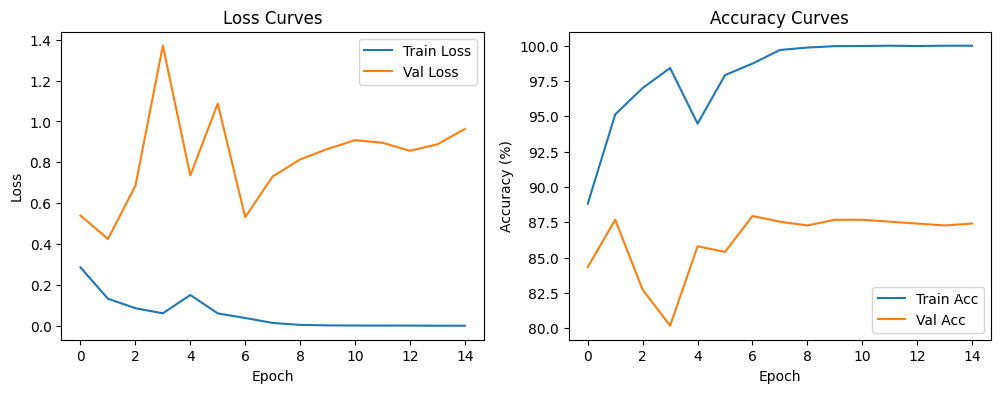

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

In [23]:
model.eval()
test_loss, correct, total = 0.0, 0, 0
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_loader)
test_acc = 100. * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')
print('\nClassification Report:')
print(classification_report(all_labels, all_preds, target_names=classes))
print('\nConfusion Matrix:')
print(confusion_matrix(all_labels, all_preds))

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:02<00:00, 21.30it/s]

Test Loss: 0.8607, Test Accuracy: 87.76%

Classification Report:
              precision    recall  f1-score   support

  EOSINOPHIL       0.91      0.84      0.87       436
  LYMPHOCYTE       0.99      1.00      0.99       434
    MONOCYTE       1.00      0.76      0.86       434
  NEUTROPHIL       0.70      0.92      0.79       436

    accuracy                           0.88      1740
   macro avg       0.90      0.88      0.88      1740
weighted avg       0.90      0.88      0.88      1740


Confusion Matrix:
[[367   6   0  63]
 [  0 433   1   0]
 [  0   0 328 106]
 [ 37   0   0 399]]


In [24]:
torch.save(model.state_dict(), 'resnet18_blood_cells.pth')
print("Model saved as 'resnet18_blood_cells.pth'")

Model saved as 'resnet18_blood_cells.pth'


In [31]:
sample_idx = 100  # Change to test a different image
sample_image, sample_label = test_dataset[sample_idx]
sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension
model.eval()
with torch.no_grad():
    output = model(sample_image)
    pred_class = classes[output.argmax(1).item()]
    confidence = torch.softmax(output, dim=1).max().item()
print(f"Sample Prediction: {pred_class} (confidence: {confidence:.2f}), True Label: {classes[sample_label]}")

Sample Prediction: EOSINOPHIL (confidence: 0.98), True Label: EOSINOPHIL


# Testing with GRADCAM

In [32]:
model = resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
model.load_state_dict(torch.load('resnet18_blood_cells.pth', map_location=device))
model = model.to(device)
model.eval()



/home/uday.g/.conda/envs/usago_env/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/uday.g/.conda/envs/usago_env/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
# Grad-CAM implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)
    
    def save_activations(self, module, input, output):
        self.activations = output
    
    def save_gradients(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]
    
    def __call__(self, x, class_idx=None):
        # Forward pass
        output = self.model(x)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        
        # Zero gradients
        self.model.zero_grad()
        # Get the score for the target class
        score = output[:, class_idx].sum()
        # Backward pass
        score.backward()
        
        # Compute Grad-CAM
        gradients = self.gradients
        activations = self.activations
        weights = torch.mean(gradients, dim=[2, 3], keepdim=True)
        cam = torch.relu(torch.sum(weights * activations, dim=1))
        
        # Normalize CAM
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam.detach().cpu().numpy()



In [41]:
# Function to overlay heatmap on original image
def overlay_heatmap(heatmap, image, alpha=0.4):
    # Resize heatmap to match image size
    heatmap_resized = cv2.resize(heatmap, (224, 224))  # Explicitly set to 224x224
    # Convert heatmap to RGB
    heatmap_rgb = np.uint8(255 * heatmap_resized)
    heatmap_rgb = cv2.applyColorMap(heatmap_rgb, cv2.COLORMAP_JET)
    
    # Denormalize image
    image = image.transpose(1, 2, 0)  # (C, H, W) to (H, W, C)
    image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
    image = np.clip(image, 0, 255).astype(np.uint8)
    
    # Debug shapes
    print(f"Heatmap shape: {heatmap_rgb.shape}, Image shape: {image.shape}")
    
    # Ensure both are uint8 and same shape
    if heatmap_rgb.shape != image.shape:
        raise ValueError(f"Shape mismatch: Heatmap {heatmap_rgb.shape}, Image {image.shape}")
    
    # Overlay
    overlaid = cv2.addWeighted(image, 1 - alpha, heatmap_rgb, alpha, 0)
    return overlaid, heatmap_resized  # Return both overlaid and raw heatmap

Generating Grad-CAM:   0%|                                                                                                              | 0/5 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9607843039035797].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9764706132411958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9725490140914916].
Generating Grad-CAM:  60%|█████████████████████████████████████████████████████████████▏                                        | 3/5 [00:00<00:00, 20.58it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9843137052059174].


Heatmap shape: (224, 224, 3), Image shape: (224, 224, 3)
Heatmap shape: (224, 224, 3), Image shape: (224, 224, 3)
Heatmap shape: (224, 224, 3), Image shape: (224, 224, 3)
Heatmap shape: (224, 224, 3), Image shape: (224, 224, 3)
Heatmap shape: (224, 224, 3), Image shape: (224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9843137052059174].
Generating Grad-CAM: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.69it/s]


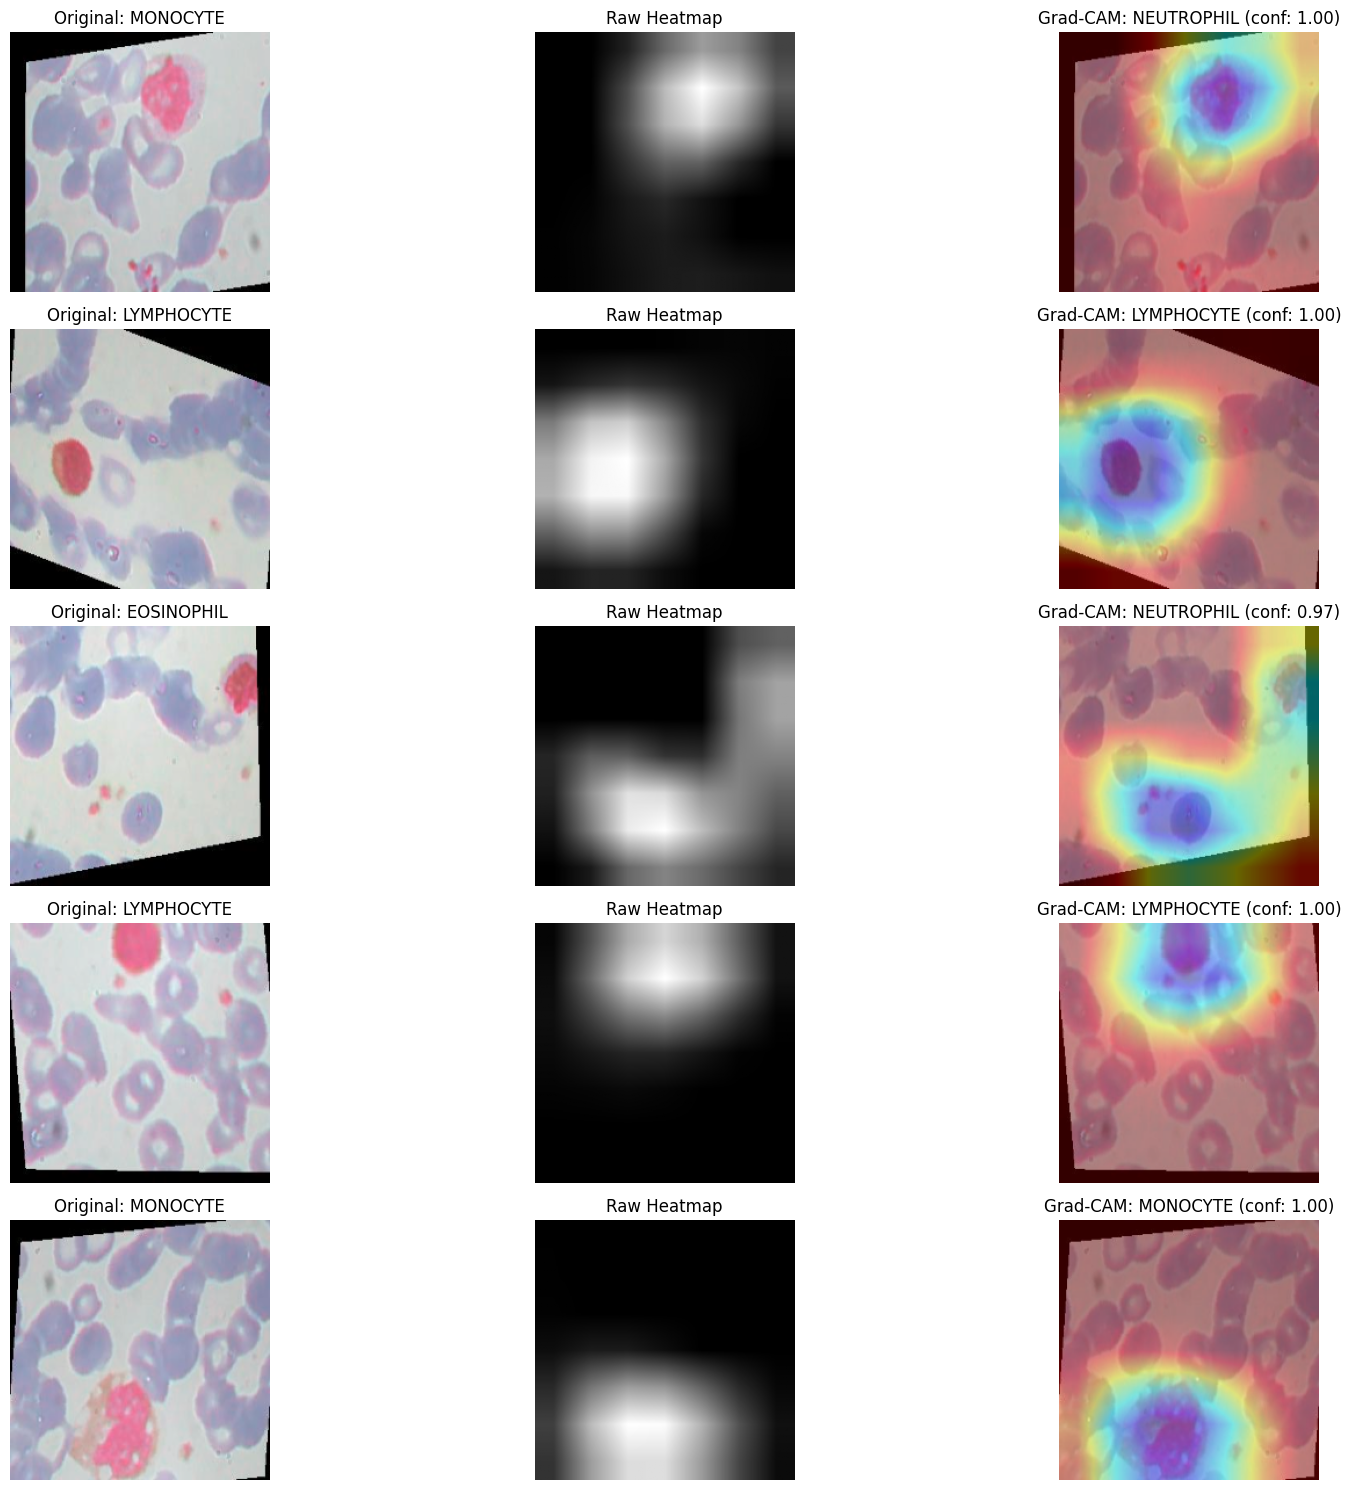

In [43]:
num_samples = 5
gradcam = GradCAM(model, model.layer4[1].conv2)

plt.figure(figsize=(18, 3 * num_samples))  # Adjusted for 3 subplots
for i in tqdm(range(num_samples), desc="Generating Grad-CAM"):
    image, label = test_dataset[i]
    image_input = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_input)
        pred_class = classes[output.argmax(1).item()]
        confidence = torch.softmax(output, dim=1).max().item()
    
    heatmap = gradcam(image_input, class_idx=output.argmax(1).item())
    overlaid_image, raw_heatmap = overlay_heatmap(heatmap[0], image.cpu().numpy())
    
    # Plot original image
    plt.subplot(num_samples, 3, 3 * i + 1)
    plt.imshow(image.cpu().numpy().transpose(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
    plt.title(f"Original: {classes[label]}")
    plt.axis('off')
    
    # Plot raw heatmap
    plt.subplot(num_samples, 3, 3 * i + 2)
    plt.imshow(raw_heatmap, cmap='gray')
    plt.title("Raw Heatmap")
    plt.axis('off')
    
    # Plot overlaid image
    plt.subplot(num_samples, 3, 3 * i + 3)
    plt.imshow(overlaid_image)
    plt.title(f"Grad-CAM: {pred_class} (conf: {confidence:.2f})")
    plt.axis('off')

plt.tight_layout()
plt.show()



In [38]:
# Evaluate on test set (for completeness)
criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
test_loss, correct, total = 0.0, 0, 0
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_loader)
test_acc = 100. * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')
print('\nClassification Report:')
print(classification_report(all_labels, all_preds, target_names=classes))
print('\nConfusion Matrix:')
print(confusion_matrix(all_labels, all_preds))

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:02<00:00, 20.56it/s]

Test Loss: 0.8607, Test Accuracy: 87.76%

Classification Report:
              precision    recall  f1-score   support

  EOSINOPHIL       0.91      0.84      0.87       436
  LYMPHOCYTE       0.99      1.00      0.99       434
    MONOCYTE       1.00      0.76      0.86       434
  NEUTROPHIL       0.70      0.92      0.79       436

    accuracy                           0.88      1740
   macro avg       0.90      0.88      0.88      1740
weighted avg       0.90      0.88      0.88      1740


Confusion Matrix:
[[367   6   0  63]
 [  0 433   1   0]
 [  0   0 328 106]
 [ 37   0   0 399]]
